# Mushroom Classification_T2_dslanders

Special thanks to [Satya](https://www.kaggle.com/code/satyaprakashshukl/mushroom-classification-analysis) for their original work. I have added a section on skewness handling and changed the n_estimators parameter from 100 to 200 in the XGBoost model.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import gc

import warnings


# Load the data

In [2]:
sub=pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
train=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

# Dataset Overview

In [3]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [4]:
print(f'Train data:\nShape:\n{train.shape}')
print('=============================')
print(f'test data:\nShape:\n{test.shape}')

Train data:
Shape:
(3116945, 22)
test data:
Shape:
(2077964, 21)


In [5]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

In [6]:
# info
print('info of train data:\n', train.info())
print('info of test data:\n', test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB
info of train data:
 None
<

In [7]:
print(f'Null values in each column in train data:\n{train.isnull().sum()}')
print('========================================')
print(f'Null values in each column in test data:\n{test.isnull().sum()}')

Null values in each column in train data:
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64
Null values in each column in test data:
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-col

In [8]:
train.describe(include='number')

,cap-diameter,stem-height,stem-width
count,3.116941e+06,3.116945e+06,3.116945e+06
mean,6.309848e+00,6.348333e+00,1.115379e+01
std,4.657931e+00,2.699755e+00,8.095477e+00
min,3.000000e-02,0.000000e+00,0.000000e+00
25%,3.320000e+00,4.670000e+00,4.970000e+00
50%,5.750000e+00,5.880000e+00,9.650000e+00
75%,8.240000e+00,7.410000e+00,1.563000e+01
max,8.067000e+01,8.872000e+01,1.029000e+02


In [9]:
train.describe(include='O').T

,count,unique,top,freq
class,3116945,2,p,1705396
cap-shape,3116905,74,x,1436026
cap-surface,2445922,83,t,460777
cap-color,3116933,78,n,1359542
does-bruise-or-bleed,3116937,26,f,2569743
gill-attachment,2593009,78,a,646034
gill-spacing,1858510,48,c,1331054
gill-color,3116888,63,w,931538
stem-root,359922,38,b,165801
stem-surface,1136084,60,s,327610


# EDA and Viualization

In [10]:
def plot_numerics(data):
    numeric_columns = ['cap-diameter', 'stem-height', 'stem-width']
    # Plotting histograms and box plots for each numeric column
    for column in numeric_columns:
        _, ax = plt.subplots(1,2, figsize=(16, 5))
        ax=ax.flatten()

        # Histogram
        #sns.histplot(data[column], bins=10, kde=True, color='skyblue', ax=ax[0])
        sns.histplot(data[column],kde=True, color='skyblue', ax=ax[0])
        ax[0].set_title(f'Histogram of {column}', fontsize=15,fontweight='bold')
        ax[0].set_xlabel(column, fontsize=12)
        ax[0].set_ylabel('Frequency', fontsize=12)

        # Box plot
        sns.boxplot(x=data[column], color='lightgreen', ax=ax[1])
        ax[1].set_title(f'Box plot of {column}', fontsize=15,fontweight='bold')
        ax[1].set_xlabel(column, fontsize=12)

        plt.tight_layout()
        plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


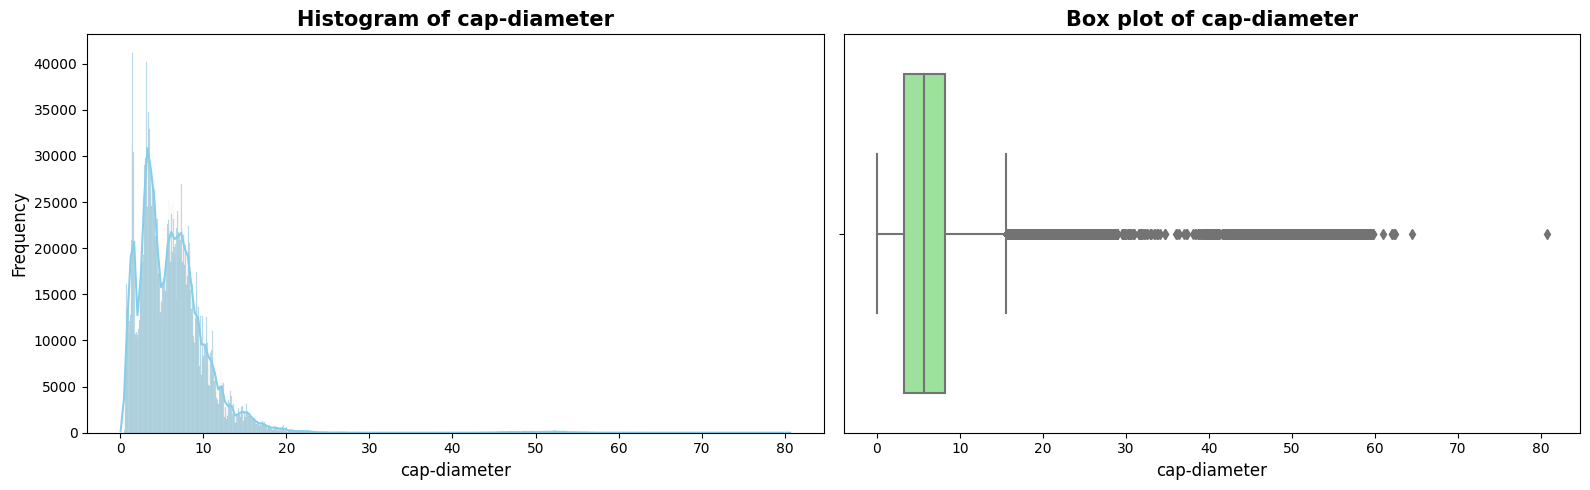

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


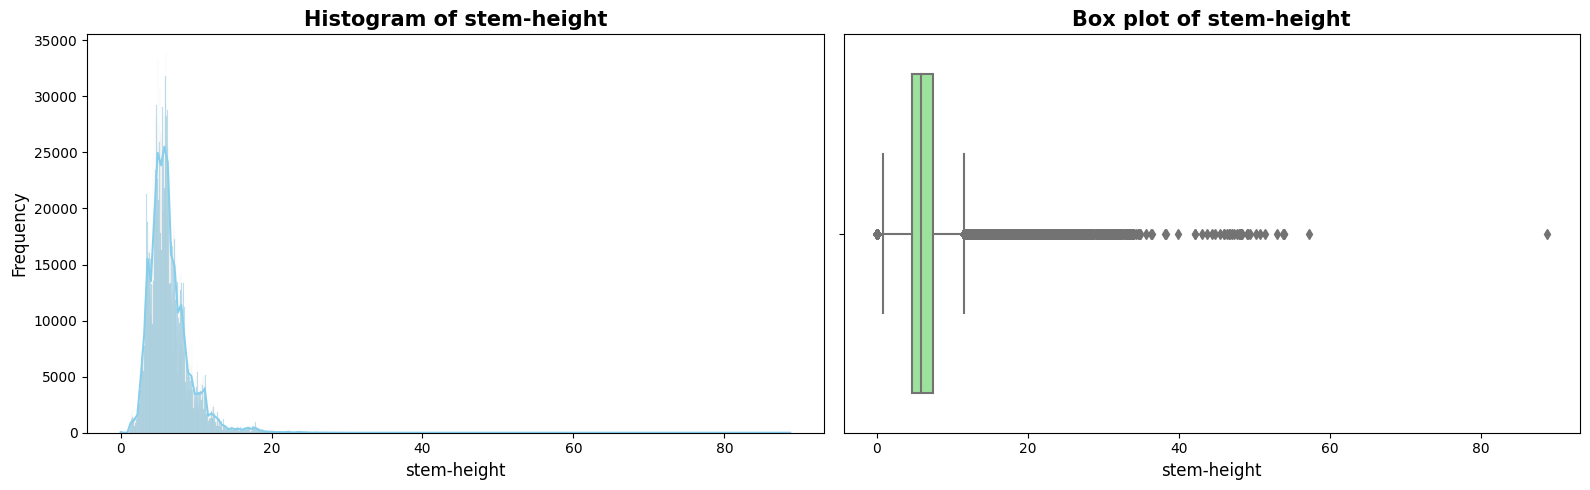

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


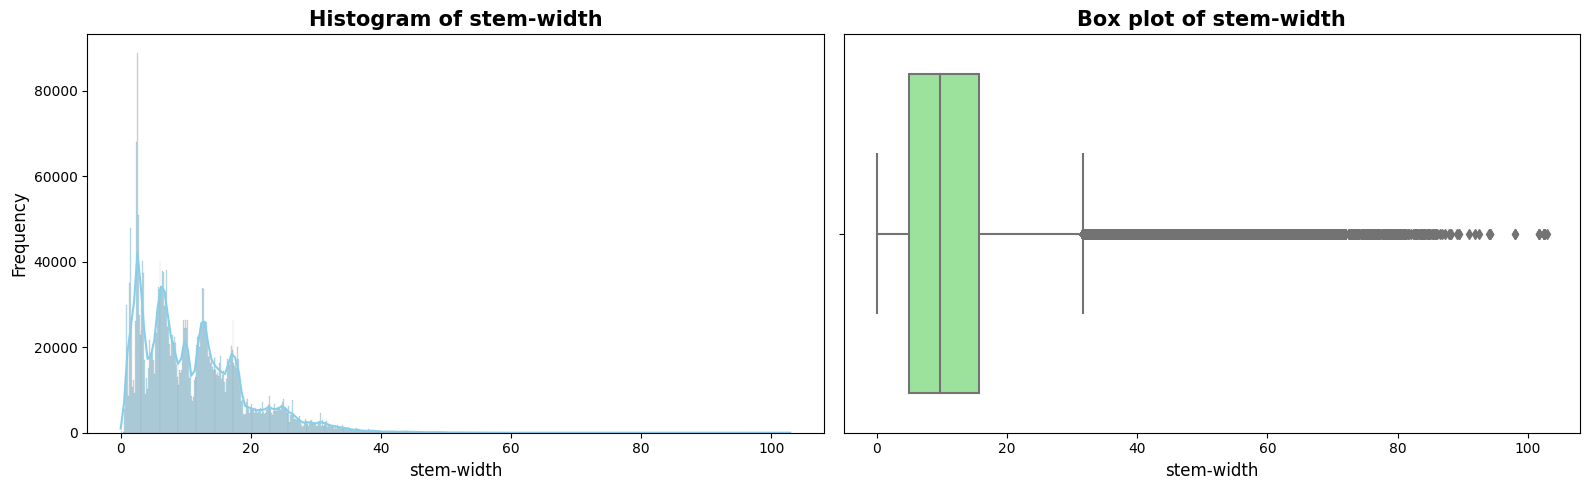

In [11]:
numeric_columns = ['cap-diameter', 'stem-height', 'stem-width']
plot_numerics(train[numeric_columns])

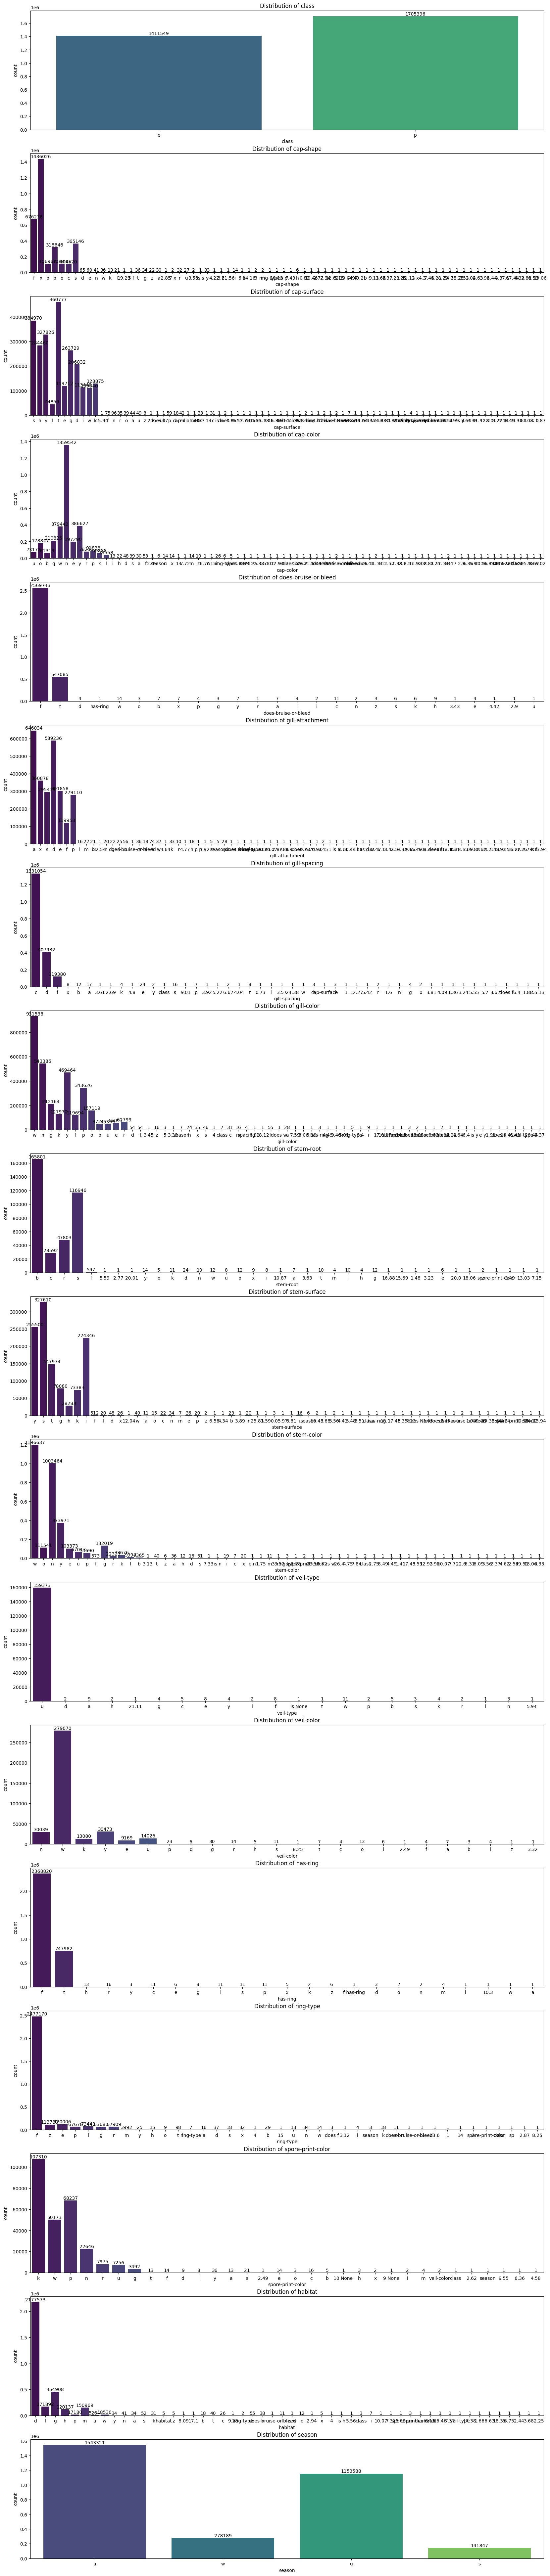

In [12]:
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(18, 1, figsize=(20, 100))
axes = axes.flatten()

categorical_columns = train.select_dtypes(include=['object']).columns

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels())

    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=10, xytext=(0, 5),
                         textcoords='offset points')

In [13]:
missing_train = train.isnull().mean() * 100
missing_test = test.isnull().mean() * 100

print("Columns in train with more than 65% missing values:")
print(missing_train[missing_train > 65])

print("\nColumns in df_test with more than 65% missing values:")
print(missing_test[missing_test > 65])

Columns in train with more than 65% missing values:
stem-root            88.452732
veil-type            94.884350
veil-color           87.936970
spore-print-color    91.425482
dtype: float64

Columns in df_test with more than 65% missing values:
stem-root            88.452543
veil-type            94.878689
veil-color           87.880445
spore-print-color    91.417224
dtype: float64


# Preprocessing

## Filling Null Values

In [14]:
cols_to_drop_train = missing_train[missing_train > 65].index
cols_to_drop_test = missing_test[missing_test > 65].index

train = train.drop(columns=cols_to_drop_train)
test = test.drop(columns=cols_to_drop_test)

In [15]:
num_cols = train.select_dtypes(include=['float64']).columns
train[num_cols] = train[num_cols].fillna(train[num_cols].median())
test[num_cols] = test[num_cols].fillna(test[num_cols].median())

In [16]:
# train data
cat_cols_train = train.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']

for col in cat_cols_train:
    most_frequent_value_train = train[col].mode()[0]
    train[col].fillna(most_frequent_value_train, inplace=True)

In [17]:
# test data
cat_cols_test = test.select_dtypes(include=['object']).columns
cat_cols_common = [col for col in cat_cols_train if col in cat_cols_test]
for col in cat_cols_common:
    most_frequent_value_train = train[col].mode()[0]
    test[col].fillna(most_frequent_value_train, inplace=True)

## Label Encoding

In [18]:
from sklearn.preprocessing import OrdinalEncoder

cat_cols_train = train.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train[cat_cols_train] = ordinal_encoder.fit_transform(train[cat_cols_train].astype(str))
test[cat_cols_train] = ordinal_encoder.transform(test[cat_cols_train].astype(str))

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['class'] = le.fit_transform(train['class'])

## Checking the skewness

In [20]:
numerical_col = ['cap-diameter', 'stem-height', 'stem-width']

numeric_data = train[numerical_col]
numeric_test = test[numerical_col]

skewness = numeric_data.apply(skew)
skewness_test = numeric_test.apply(skew)

print("Skewness of numerical features in train data:")
print(skewness)
print("\nSkewness of numerical features in test data:")
print(skewness_test)

Skewness of numerical features in train data:
cap-diameter    3.972610
stem-height     1.926681
stem-width      1.235426
dtype: float64

Skewness of numerical features in test data:
cap-diameter    4.957166
stem-height     1.921951
stem-width      1.249340
dtype: float64


In [21]:
skewed_columns = ['cap-diameter', 'stem-height', 'stem-width']


for column in skewed_columns:
    train[f'{column}_sqrt'] = np.sqrt(train[column])
    train[f'{column}_log'] = np.log1p(train[column])

# Calculate skewness before and after transformations
skewness_before = train[skewed_columns].apply(skew)
skewness_after_sqrt = train[[f'{column}_sqrt' for column in skewed_columns]].apply(skew)
skewness_after_log = train[[f'{column}_log' for column in skewed_columns]].apply(skew)

# Print skewness before and after transformations
print("Skewness before transformation:")
print(skewness_before)
print("\nSkewness after square root transformation:")
print(skewness_after_sqrt)
print("\nSkewness after log transformation:")
print(skewness_after_log)

Skewness before transformation:
cap-diameter    3.972610
stem-height     1.926681
stem-width      1.235426
dtype: float64

Skewness after square root transformation:
cap-diameter_sqrt    0.903852
stem-height_sqrt     0.868054
stem-width_sqrt      0.296952
dtype: float64

Skewness after log transformation:
cap-diameter_log   -0.117678
stem-height_log     0.240165
stem-width_log     -0.317927
dtype: float64


In [22]:
train = train.drop(['cap-diameter', 'cap-diameter_sqrt',
                  'stem-height', 'stem-height_sqrt',
                  'stem-width', 'stem-width_log',
                    ], axis=1)

In [23]:
skewed_columns = ['cap-diameter', 'stem-height', 'stem-width']


for column in skewed_columns:
    test[f'{column}_sqrt'] = np.sqrt(test[column])
    test[f'{column}_log'] = np.log1p(test[column])

# Calculate skewness before and after transformations
skewness_before = test[skewed_columns].apply(skew)
skewness_after_sqrt = test[[f'{column}_sqrt' for column in skewed_columns]].apply(skew)
skewness_after_log = test[[f'{column}_log' for column in skewed_columns]].apply(skew)

# Print skewness before and after transformations
print("Skewness before transformation:")
print(skewness_before)
print("\nSkewness after square root transformation:")
print(skewness_after_sqrt)
print("\nSkewness after log transformation:")
print(skewness_after_log)

Skewness before transformation:
cap-diameter    4.957166
stem-height     1.921951
stem-width      1.249340
dtype: float64

Skewness after square root transformation:
cap-diameter_sqrt    0.921530
stem-height_sqrt     0.873198
stem-width_sqrt      0.300236
dtype: float64

Skewness after log transformation:
cap-diameter_log   -0.113660
stem-height_log     0.245913
stem-width_log     -0.316793
dtype: float64


In [24]:
test = test.drop(['cap-diameter', 'cap-diameter_sqrt',
                  'stem-height', 'stem-height_sqrt',
                  'stem-width', 'stem-width_log',
                    ], axis=1)

## Split data

In [25]:
y = train['class'] 
X = train.drop(['class'],axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state =42, shuffle=True, stratify=train['class'])

# Modeling- XGBoost

In [27]:
from sklearn.metrics import matthews_corrcoef

def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [28]:
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier
import gc

model = XGBClassifier(                    
    #alpha=0.1,                   
    #subsample=0.8,                
    colsample_bytree=0.6,      
    max_depth=14,             
    min_child_weight=7,         
    #gamma=1e-6,                
    random_state=42,                 
    n_estimators=200             
    )

In [29]:
XGB = model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)],
    eval_metric=mcc_metric)

[0]	validation_0-logloss:0.45669	validation_0-mcc:0.94024
[1]	validation_0-logloss:0.34633	validation_0-mcc:0.96556
[2]	validation_0-logloss:0.26478	validation_0-mcc:0.96860
[3]	validation_0-logloss:0.20798	validation_0-mcc:0.97041
[4]	validation_0-logloss:0.16472	validation_0-mcc:0.97121
[5]	validation_0-logloss:0.13481	validation_0-mcc:0.97341
[6]	validation_0-logloss:0.10966	validation_0-mcc:0.97601
[7]	validation_0-logloss:0.09409	validation_0-mcc:0.97634
[8]	validation_0-logloss:0.08139	validation_0-mcc:0.97721
[9]	validation_0-logloss:0.07282	validation_0-mcc:0.97764
[10]	validation_0-logloss:0.06532	validation_0-mcc:0.97864
[11]	validation_0-logloss:0.06106	validation_0-mcc:0.97877
[12]	validation_0-logloss:0.05570	validation_0-mcc:0.97957
[13]	validation_0-logloss:0.05277	validation_0-mcc:0.97973
[14]	validation_0-logloss:0.04971	validation_0-mcc:0.98010
[15]	validation_0-logloss:0.04761	validation_0-mcc:0.98033
[16]	validation_0-logloss:0.04599	validation_0-mcc:0.98054
[17]	va

In [30]:
y_pred = XGB.predict(X_test)

In [31]:
score = matthews_corrcoef(y_test, y_pred)
print('MCC:', score)

MCC: 0.9826003964704649


# Submission

In [32]:
test_pred_prob = XGB.predict(test)

In [33]:
test_pred_binary = (test_pred_prob > 0.5).astype(int)

test_pred_class = le.inverse_transform(test_pred_prob)

In [34]:
sub['class']= test_pred_class

In [35]:
sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e
